# Recipe classification `14 points`

Source: `recipes.csv`, which I scraped from... somewhere. Each row represents a recipe.

**Topics**

* Filtering
* Text analysis
* Classification

In [1]:
# !pip install pystemmer
# !pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import Stemmer
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [3]:
df = pd.read_csv('recipes.csv')

## Filtering and aggregating `3 points`

### What is the most common cuisine in this dataset?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cuisine          39774 non-null  object
 1   id               39774 non-null  int64 
 2   ingredient_list  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [5]:
# Italian
df.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

### Plot a bar graph of cuisine popularity, with the most common at the top

<AxesSubplot:>

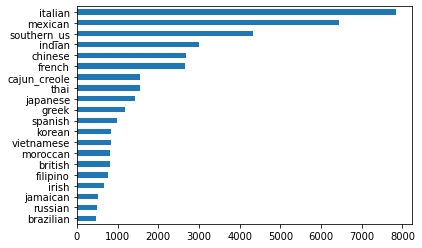

In [6]:
df.cuisine.value_counts(ascending=True).plot(kind='barh')

### Clean up the names so we get nicer graphics

"southern_us" should be "Southern US," "russian" should be "Russian," etc.

In [7]:
df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [8]:
old_names = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican','spanish', 'italian', 'mexican', 'chinese', 'british', 
'thai','vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese','irish', 'korean', 'moroccan', 'russian']

In [9]:
new_names = ['Greek', 'Southern US', 'Filipino', 'Indian', 'Jamaican','Spanish', 'Italian', 'Mexican', 'Chinese', 'British', 
'Thai','Vietnamese', 'Cajun Creole', 'Brazilian', 'French', 'Japanese','Irish', 'Korean', 'Moroccan', 'Russian']

In [10]:
name_replace = dict(zip(old_names, new_names))

name_replace

{'greek': 'Greek',
 'southern_us': 'Southern US',
 'filipino': 'Filipino',
 'indian': 'Indian',
 'jamaican': 'Jamaican',
 'spanish': 'Spanish',
 'italian': 'Italian',
 'mexican': 'Mexican',
 'chinese': 'Chinese',
 'british': 'British',
 'thai': 'Thai',
 'vietnamese': 'Vietnamese',
 'cajun_creole': 'Cajun Creole',
 'brazilian': 'Brazilian',
 'french': 'French',
 'japanese': 'Japanese',
 'irish': 'Irish',
 'korean': 'Korean',
 'moroccan': 'Moroccan',
 'russian': 'Russian'}

<AxesSubplot:>

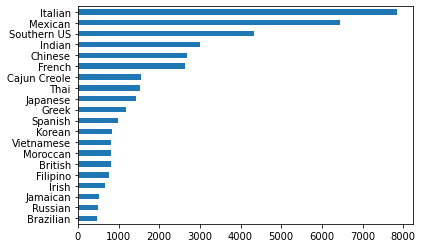

In [11]:
df.cuisine = df.cuisine.replace(name_replace)

df.cuisine.value_counts(ascending=True).plot(kind='barh')

## Text analysis

### Build a classifier to predict whether a recipe is Greek or not `2 points`

In [12]:
df['greek'] = df['cuisine']
df.loc[df['cuisine'] != 'Greek','greek'] = 'Not Greek'

In [13]:
df.tail(20)

,cuisine,id,ingredient_list,greek
39754,Vietnamese,27082,"jasmine rice, bay leaves, sticky rice, rotisse...",Not Greek
39755,Indian,36337,"mint leaves, cilantro leaves, ghee, tomatoes, ...",Not Greek
39756,Mexican,15508,"vegetable oil, cinnamon sticks, water, all-pur...",Not Greek
39757,Greek,34331,"red bell pepper, garlic cloves, extra-virgin o...",Greek
39758,Greek,47387,"milk, salt, ground cayenne pepper, ground lamb...",Greek
39759,Korean,12153,"red chili peppers, sea salt, onions, water, ch...",Not Greek
39760,Southern US,41840,"butter, large eggs, cornmeal, baking powder, b...",Not Greek
39761,Chinese,6487,"honey, chicken breast halves, cilantro leaves,...",Not Greek
39762,Indian,26646,"curry powder, salt, chicken, water, vegetable ...",Not Greek
39763,Italian,44798,"fettuccine pasta, low-fat cream cheese, garlic...",Not Greek


In [14]:
stemmer = Stemmer.Stemmer('en')

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

In [15]:
vectorizer = StemmedTfidfVectorizer()
vectors = vectorizer.fit_transform(df.ingredient_list)
words_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())
words_df

,00,10,100,14,15,25,33,40,43,95,...,yuzukosho,za,zatarain,zero,zest,zesti,zinfandel,ziti,zucchini,épice
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
39770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.346583,0.0,0.0,0.0,0.0
39771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
39772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [16]:
clf = LinearSVC()

In [17]:
X = words_df
y = df.greek

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)


0.9865245374094932

### Using a confusion matrix, show how well it classifies Greek recipes `1 point`

It won't be perfect, but it shouldn't be *completely awful*.

In [19]:
y_true = y_test
y_pred = clf.predict(X_test)
label_names = y_true.unique()
matrix = confusion_matrix(y_true, y_pred,labels=label_names)
pd.DataFrame(matrix,
      columns='Predicted ' + label_names,
      index='Is ' + label_names)

,Predicted Greek,Predicted Not Greek
Is Greek,180,102
Is Not Greek,32,9630


### List the top 20 ingredients that predict a recipe to be greek or a recipe to be not greek `2 points`

In [20]:
eli5.show_weights(clf, top=(21, 20), feature_names=vectorizer.get_feature_names())

Weight?,Feature
+2.496,cilantro
+2.096,ginger
+1.961,tortilla
+1.724,cumin
+1.706,salmon
+1.601,orecchiett
+1.486,masala
+1.463,<BIAS>
+1.460,baguett
+1.319,garam


## Create, evaluate, and examine the weights of a Mexican food classifier `3 points`

In [21]:
df['mexican'] = df['cuisine']
df.loc[df['cuisine'] != 'Mexican','mexican'] = 'Not Mexican'

In [22]:
df.tail()

,cuisine,id,ingredient_list,greek,mexican
39769,Irish,29109,"light brown sugar, granulated sugar, butter, w...",Not Greek,Not Mexican
39770,Italian,11462,"KRAFT Zesty Italian Dressing, purple onion, br...",Not Greek,Not Mexican
39771,Irish,2238,"eggs, citrus fruit, raisins, sourdough starter...",Not Greek,Not Mexican
39772,Chinese,41882,"boneless chicken skinless thigh, minced garlic...",Not Greek,Not Mexican
39773,Mexican,2362,"green chile, jalapeno chilies, onions, ground ...",Not Greek,Mexican


In [23]:
X = words_df
y = df.mexican

In [24]:
X = words_df
y = df.mexican

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.9714400643604183

In [25]:
y_true = y_test
y_pred = clf.predict(X_test)
label_names = y_true.unique()
matrix = confusion_matrix(y_true, y_pred,labels=label_names)
pd.DataFrame(matrix,
      columns='Predicted ' + label_names,
      index='Is ' + label_names)

,Predicted Not Mexican,Predicted Mexican
Is Not Mexican,8286,92
Is Mexican,192,1374


In [26]:
eli5.show_weights(clf, top=(21, 20), feature_names=vectorizer.get_feature_names())

Weight?,Feature
+3.052,ginger
+2.813,fish
+2.539,crawfish
+2.238,curri
+2.191,masala
+2.132,grit
+1.856,eye
+1.816,tumer
+1.746,catfish
+1.738,star


## Multi-class classification `3 points`

### Encode the recipe names as numbers

Let's convert each label - greek, southern US, indian, etc - to be a number. You can have this code:

```py
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['cuisine_label'] = le.fit_transform(df.cuisine)
df.head()
```

In [27]:
le = preprocessing.LabelEncoder()
df['cuisine_label'] = le.fit_transform(df.cuisine)
df.head()

,cuisine,id,ingredient_list,greek,mexican,cuisine_label
0,Greek,10259,"romaine lettuce, black olives, grape tomatoes,...",Greek,Not Mexican,6
1,Southern US,25693,"plain flour, ground pepper, salt, tomatoes, gr...",Not Greek,Not Mexican,16
2,Filipino,20130,"eggs, pepper, salt, mayonaise, cooking oil, gr...",Not Greek,Not Mexican,4
3,Indian,22213,"water, vegetable oil, wheat, salt",Not Greek,Not Mexican,7
4,Indian,13162,"black pepper, shallots, cornflour, cayenne pep...",Not Greek,Not Mexican,7


### Build a classifier to predict this new `cuisine_label` column

In [28]:
X = words_df
y = df.cuisine_label

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7811745776347546

### Using a confusion matrix, see what cuisines it confuses

Here's the multi-class version:

```py
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(le.classes_)
scores = pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)
scores.style.background_gradient(cmap='YlGnBu')
```

In [29]:
y_true = y_test
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_true, y_pred)

label_names = pd.Series(le.classes_)
scores = pd.DataFrame(matrix,
     columns='Predicted ' + label_names,
     index='Is ' + label_names).div(matrix.sum(axis=1), axis=0)
scores.style.background_gradient(cmap='YlGnBu')

,Predicted Brazilian,Predicted British,Predicted Cajun Creole,Predicted Chinese,Predicted Filipino,Predicted French,Predicted Greek,Predicted Indian,Predicted Irish,Predicted Italian,Predicted Jamaican,Predicted Japanese,Predicted Korean,Predicted Mexican,Predicted Moroccan,Predicted Russian,Predicted Southern US,Predicted Spanish,Predicted Thai,Predicted Vietnamese
Is Brazilian,0.487179,0.008547,0.059829,0.008547,0.017094,0.059829,0.000000,0.017094,0.000000,0.025641,0.008547,0.000000,0.000000,0.153846,0.000000,0.000000,0.068376,0.025641,0.059829,0.000000
Is British,0.000000,0.396040,0.019802,0.000000,0.004950,0.138614,0.000000,0.049505,0.064356,0.099010,0.014851,0.000000,0.000000,0.019802,0.000000,0.014851,0.168317,0.000000,0.004950,0.004950
Is Cajun Creole,0.002532,0.002532,0.751899,0.005063,0.000000,0.030380,0.000000,0.000000,0.000000,0.058228,0.005063,0.000000,0.000000,0.010127,0.000000,0.002532,0.121519,0.007595,0.000000,0.002532
Is Chinese,0.000000,0.000000,0.002959,0.847633,0.008876,0.005917,0.000000,0.010355,0.001479,0.013314,0.001479,0.026627,0.022189,0.008876,0.000000,0.000000,0.010355,0.000000,0.022189,0.017751
Is Filipino,0.050279,0.005587,0.011173,0.111732,0.569832,0.011173,0.005587,0.005587,0.000000,0.033520,0.000000,0.005587,0.011173,0.055866,0.000000,0.016760,0.061453,0.005587,0.016760,0.022346
Is French,0.001495,0.016442,0.010463,0.002990,0.002990,0.605381,0.010463,0.010463,0.008969,0.198804,0.000000,0.004484,0.000000,0.007474,0.007474,0.020927,0.068759,0.020927,0.001495,0.000000
Is Greek,0.003268,0.000000,0.000000,0.000000,0.000000,0.042484,0.653595,0.016340,0.000000,0.176471,0.003268,0.000000,0.000000,0.019608,0.022876,0.009804,0.026144,0.022876,0.000000,0.003268
Is Indian,0.001294,0.002587,0.000000,0.000000,0.003881,0.002587,0.012937,0.918499,0.000000,0.009056,0.002587,0.001294,0.002587,0.012937,0.015524,0.002587,0.006468,0.002587,0.002587,0.000000
Is Irish,0.000000,0.056497,0.005650,0.000000,0.005650,0.141243,0.016949,0.011299,0.474576,0.033898,0.005650,0.000000,0.000000,0.016949,0.005650,0.016949,0.180791,0.022599,0.000000,0.005650
Is Italian,0.000000,0.001004,0.005519,0.000502,0.000502,0.041646,0.009533,0.002509,0.000502,0.895133,0.000502,0.000000,0.000000,0.009032,0.002007,0.004014,0.020572,0.006523,0.000502,0.000000


### What cuisine is it most likely to confuse a Vietnamese recipe with?

In [30]:
# Thai cuisine
scores.filter(['Is Vietnamese'],axis=0).T.sort_values(by='Is Vietnamese',ascending=False)[1:2]

,Is Vietnamese
Predicted Thai,0.253968


### What cuisine is it the worst at classifying?

In [31]:
# British cuisine
pd.Series(np.diag(scores), index=[scores.index, scores.columns]).sort_values().head(1)

Is British  Predicted British    0.39604
dtype: float64